# Multivariate Decomposition
This notebook explores various methods to summarize high dimensional data.

In [1]:
# for the pandas database
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import glob
import pprint
import json

# to load image data
from PIL import Image

# set nice defaults for seaborn plotting library
sns.set()

As we have seen previously, adding a modest number of experimental variables can dramatically increase the complexity of the analysis. This problem is generally referred to as [the curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). To combat the issues associated with high-dimensional data, [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) methods have been developed. These methods are closely related to the concept of data compression. In either case the end result is a transformation that reduces the size of the original data, while preserving the important information.   

We will explore this problem with the faces dataset. Let's start with creating the familiar `facedb`

In [2]:
def create_facedb(dir="/srv/data/faces/generated.photos"):
    '''create a database of all the generated faces found in the supplied directory'''
    db = pd.DataFrame()
    pattern = dir + "/*.jpg"
    face_photos = glob.glob(pattern)
    db["fullpath"] = face_photos
    partitioned = db["fullpath"].str.rpartition("/")
    db["filename"] = partitioned.values[:, 2]
    db["faceid"] = db["filename"].str.extract(r"_(\d{7})[_.]")

    json_files = db["fullpath"].str.replace("/generated.photos/", 
                                            "/generated.photos_metadata/", regex=False)
    json_files = json_files.str.replace(".jpg", ".json", regex=False)
    db["jsonfile"] = json_files
    return db

def read_metadata(facedb, id):
    '''return a string containing the \"faceAttributes\" for the given face'''
    with open(facedb["jsonfile"][id]) as f:
        data = json.load(f)
    attributeInfo = pprint.pformat(data["faceAttributes"])
    return attributeInfo

# call create_facedb() to create a pandas DataFrame called "facedb"
facedb = create_facedb()

RGB images can be stored as a 3D matrix, where each pixel defined by values for red, green, and blue. This can be converted to grayscale using a weighted sum of the R, G, and B instensity values. The end result is a single value for each pixel that describes the "brightness" of that pixel. Using this conversion, images can be stored as a 2D numpy array. 

Now we will create a function that converts multiple images from the face dataset to gray scale.

In [3]:
downsample = 5
def get_pixel_data(face_ids):
    data_list = []
    for id in face_ids:
        im = Image.open(facedb["fullpath"][id], 'r')
        im_data = np.array(im.getdata())
        rgb_weights = [0.2989, 0.5870, 0.1140] # Used to convert images to grayscale
        gray_image =  np.dot(im_data, rgb_weights).reshape(256,256)
        data_list.append(gray_image[::downsample, ::downsample]) # Images are downsampled to improve efficiency
    return np.array(data_list)
num_images = 100
image_list = get_pixel_data(range(num_images))
image_shape = image_list.shape[1:] # Grab the dimensions of a single image for reshaping later

This function returns a 3D numpy array, where the first dimmension indexes a single picture, and the following 2 dimensions are the height and width. The structure can be imagined as a stack of gray-scale photos. 

(100, 52, 52)


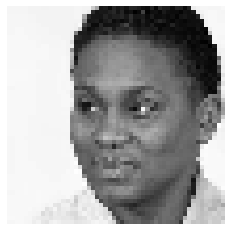

In [4]:
print(image_list.shape)
plt.imshow(image_list[0,:,:], cmap='gray')
plt.axis('off')
plt.show()

Previously we discussed the notion of "face embeddings". Specifically, assigning a vector of values to each image that somehow capture the relationships between images. For face classification, vectors that are similar to each other are more likely to be the same person. An obvious question to ask is: how do we create these face embeddings?. Now that we have converted a set of images into a 3D numpy array, the question can be rephrased as: how do we make the array smaller, without losing information about the faces?

The most common approach to dimensionality reduction is [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). The method takes in a 2D matrix, where each row corresponds to observations (or samples from an experiment), and each column corresponds to a variable. The method provides a simple transformation that reduces the number of variables necessary to describe the data. The "components", are essentially functions that take a sample with n_features, and outputs a single value that is unique for each image: `COMPONENT1(feature1, feature1, feature3, ...) -> value`. Adding more components allows for a more accurate reconstruction of the original data. 

Succinctly, (n_samples, n_features) --PCA--> (n_samples, n_components). 

To make our image data compatible with PCA, we will have to reshape it into a 2D matrix. For a single image, this is equivalent to arranging every pixel into a single line. The final output will be a new matrix with the shape (n_subjects, n_pixels). 

In [5]:
image_flattened = image_list.reshape(num_images, -1) 
print(image_list.shape)
print(image_flattened.shape)

(100, 52, 52)
(100, 2704)


Let's see how the reconstruction changes as a function of the number of components. We will utilize the scikit-learn package to perform PCA.

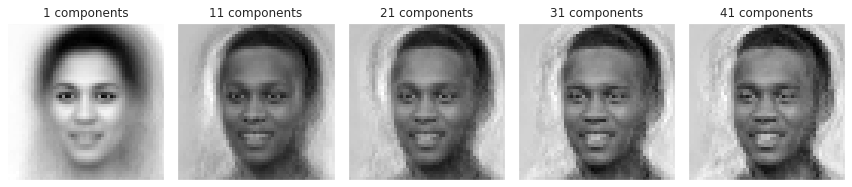

In [6]:
image_selection = 50

fig, axs = plt.subplots(1, 5, figsize=(12,6), tight_layout=True)
for idx, ax in zip(range(0,50,10), axs.reshape(-1)):
    pca = PCA(n_components=idx + 1, random_state=0)
    transformed = pca.fit_transform(image_flattened)
    reconstruction = pca.inverse_transform(transformed)
    ax.imshow(reconstruction[image_selection,:].reshape(image_shape), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'{idx+1} components')


As you can see, adding more components results in a clearer image. A nice benefit of PCA is that components are ordered in terms of "importance". The first few principal components capture the majority of the information in the dataset, but there tends to be diminishing returns as more components are added.

Now you may be wondering what these "components" actually represent, and how they are used to reconstruct new images. In the case of images, you can actually think of them as transparent layers that represent different features of the faces. By changing the transparency (or weight) of these layers, you can reconstruct different images.

To illustrate this, we will randomly pick some components and plot the features they represent.

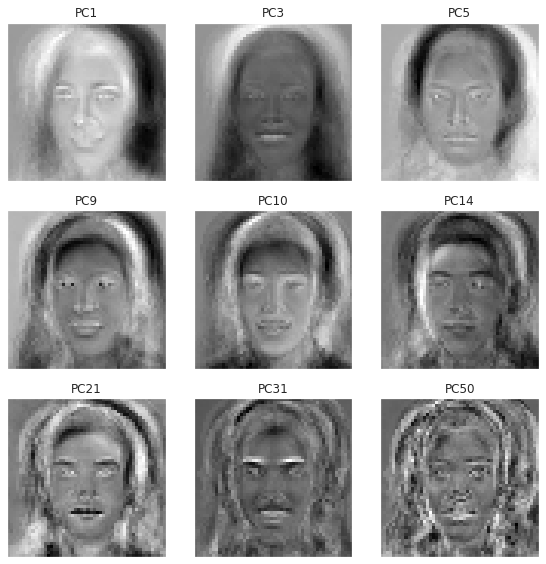

In [7]:
n_components = 50
component_list = sorted(np.random.choice(range(n_components), size=9))
pca = PCA(n_components=n_components, random_state=0)
transformed = pca.fit_transform(image_flattened)

fig, axs = plt.subplots(3, 3, figsize=(8,8), tight_layout=True)
for ax, idx in zip(axs.reshape(-1), component_list):
    eigen_face = pca.components_[idx, :].reshape(image_shape)
    ax.imshow(eigen_face, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'PC{idx+1}')


These visualizations are known as [eigen faces](https://en.wikipedia.org/wiki/Eigenface) which refers to the term eigenvectors, an alternative word for principal components that reflects the math behind the algorithm. Since each image is a weighted combination of these eigen faces, we can actually make artifical faces by choosing random weights and adding the components together.

Text(0.5, 1.0, 'Artifical Face')

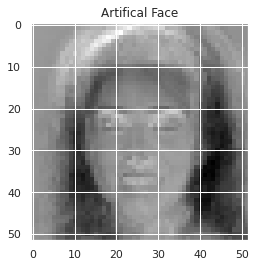

In [8]:
n_components = 50
weights = np.random.rand(50)*200 - 5
new_image = np.zeros(image_shape)
for idx in range(n_components):
    new_image += weights[idx] * pca.components_[idx, :].reshape(image_shape) * pca.explained_variance_[idx] 
    
plt.imshow(new_image, cmap='gray')    
plt.title('Artifical Face')

A final feature that is quite useful for PCA is data visualization. It is often not feasible to efficiently visualize datasets with >3 features per sample. PCA provides a method to view each sample in a lower dimensional space. Specifically, we can plot each sample according to the weights of the first 2 components. Since these first 3 components capture more information about the data, samples that are "closer" in this low-dimensional space tend to be more similar.

Text(0.5, 1.0, 'PCA Projection of face dataset')

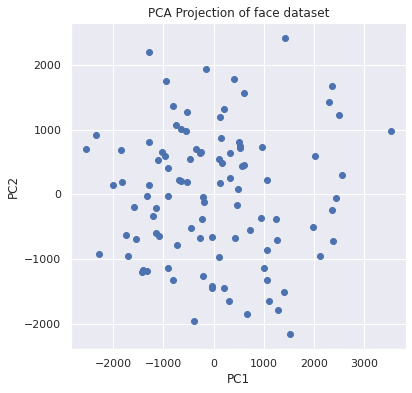

In [9]:
plt.figure(figsize=(6,6))
x, y = transformed[:,0], transformed[:,1]
plt.scatter(x,y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of face dataset')

To get a sense for how similar these photos are, we can try clustering the data points. While we can only visualize 3 dimensions, we can leverage all components for clustering. 

Text(0.5, 1.0, 'K-means clustering of face dataset')

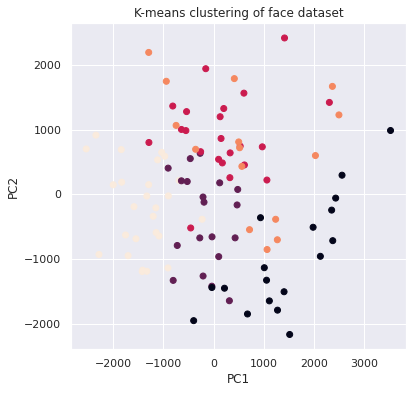

In [10]:
plt.figure(figsize=(6,6))
cluster_predictions = KMeans(n_clusters=5).fit_predict(transformed)
plt.scatter(x,y, c=cluster_predictions)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means clustering of face dataset')

Finally, we can pull out images from the clusters and see how they compare.

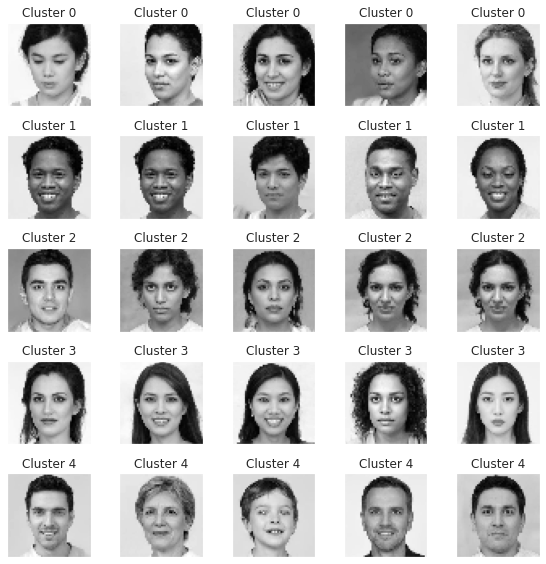

In [11]:
fig, axs_all = plt.subplots(5, 5, figsize=(8,8), tight_layout=True)
for cluster_idx, axs in zip(range(5), axs_all.reshape(5, -1)):
    cluster_positions = np.where(cluster_predictions == cluster_idx)[0]
    image_selection = np.random.choice(cluster_positions, 5)
    for image_idx, ax in zip(image_selection, axs):
        ax.imshow(image_list[image_idx,:,:], cmap='gray')
        ax.set_title(f'Cluster {cluster_idx}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

As you can see, clustering using principal components tends to capture head position. However, some clusters do capture the same subject. For face classification, alternative algorithms are necessary to emphasize facial features. Nevertheless, the concepts illustrated in this notebook are shared for the large family of dimensionality reduction methods.